In [1]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp

In [2]:
def inf_line_bessel_oriented10(k,nx,t,alpha,theta,gamma,l):
    domain = np.arange(0, nx) - nx//2
    prob = np.zeros([nx,1], dtype='complex')
    for x in range(1,nx):
        prob[x,0] = ( (np.cos(theta)**2) * (sp.jv(domain[x] + k, 2*t)**2)
                     + (np.sin(theta)**2) * (sp.jv(domain[x] - k, 2*t)**2)
                     + 2*((-1)**k)*np.cos(2*alpha*k + gamma)*np.cos(theta)*np.sin(theta)*sp.jv(domain[x] + k, 2*t)*sp.jv(domain[x] - k, 2*t))

    return prob

def getMultipleProbs(k,n,theta,l,gamma,alphaList,timeList):
    timeListList = [timeList]*len(alphaList)
    probListAux = []
    probList = []

    for alpha in alphaList:
        for t in timeList:
            psi_oriented = inf_line_bessel_oriented10(k,n,t,alpha,theta,gamma,l)
            probListAux.append(np.sum(psi_oriented[n//2-k-1:n//2+k+2]))
        probList.append(probListAux)
        probListAux = []

    return probList

def getWeightedGraph(graph,weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = np.conj(weight)
    return nx.compose(graph,revGraph)

In [3]:
n=510
alpha=np.pi/2
# alpha=0
weight = np.exp(1j*alpha)
baseGraph = nx.path_graph(n,create_using=nx.DiGraph)

graph = getWeightedGraph(baseGraph,weight)

k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
l = 0
gamma = l * np.pi

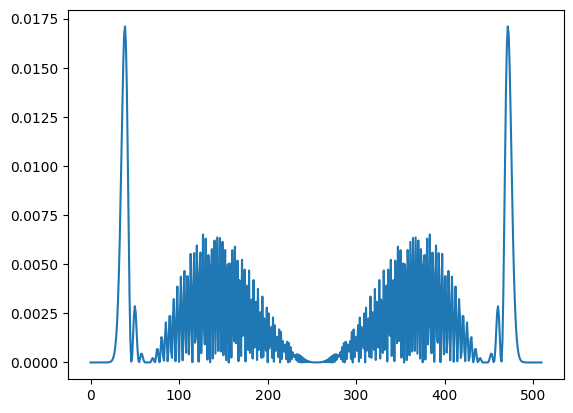

In [13]:
t = 110
initCond = [(n//2-k,(np.cos(theta))),(n//2+k,(np.exp(1j*gamma)*np.sin(theta)))]

qw = QWAK(graph,gamma=1)
qw.runWalk(t,customStateList=initCond)
plt.plot(qw.getProbVec())

In [6]:
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

qwakProbDist = qw.getProbVec()
mpl.rcParams['figure.figsize'] = [12, 4]

besselProbDist = inf_line_bessel_oriented10(k,200,t,alpha,theta,gamma,l)
plt.plot(range(-100,100),qwakProbDist,label="Numerical",linestyle='solid',color='red')
plt.plot(range(-100,100),besselProbDist,label='Analytical',linestyle='dashdot',color='blue')
plt.ylabel(r"$P(x)$",fontsize=15)
plt.xlabel("x",fontsize=15)
plt.legend(loc="upper center",ncol=2,fontsize=15)

plt.savefig(fname='numAnalyt.png')
plt.clf()

<Figure size 1200x400 with 0 Axes>

In [7]:
def multiple_oriented_walks(N,baseGraph,alphaList,initCond):
    probList = []
    for alpha in alphaList:
        weight = np.exp(1j*alpha)
        graph = getWeightedGraph(baseGraph,weight)
        qw = QWAK(graph)
        qw.runWalk(time=t,customStateList=initCond)
        probList.append(qw.getProbVec())
    return probList

In [55]:
n = 9
N=2**n
print(N)

alpha=np.pi/2
alphaList = [0, alpha/2, alpha]
alphaLabelList = [r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']

baseGraph = nx.path_graph(N,create_using=nx.DiGraph)

k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
    
l = 0
gamma = l * np.pi

t = 110
initCond = [(N//2-k,np.cos(theta)),(N//2+k,np.exp(1j*gamma)*np.sin(theta))]

probMatrix = multiple_oriented_walks(N,baseGraph,alphaList,initCond)

512


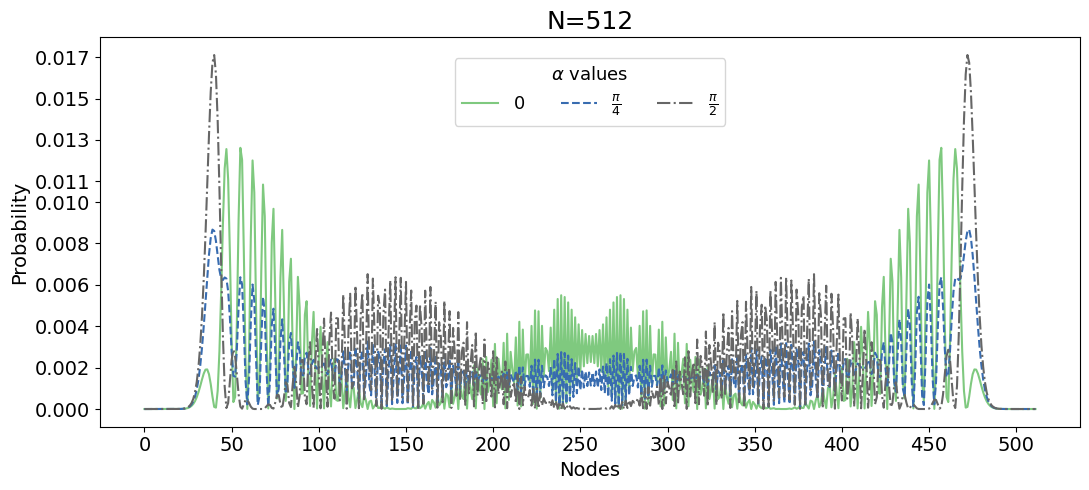

In [56]:
def plot_prob_list(probList, alphaList, fig_size=(10, 6), x_label='Node', y_label='Probability', 
                   title='Probability distribution for each node in the graph', color_map='tab10', 
                   line_width=1.5, line_style='-', x_num_ticks=20, y_num_ticks=10, 
                   x_round_val=2, y_round_val=1, xlabel=None, ylabel=None, font_size=12, 
                   alpha_labels=None, filepath=None):
    
    fig, ax = plt.subplots(figsize=fig_size)
    i=0
    # create a list of colors to use for each line
    colors = plt.cm.get_cmap(color_map)(np.linspace(0, 1, len(alphaList)))

    for prob, alpha, alphaLabel in zip(probList,alphaList,alpha_labels):
        # plot each line with custom options
        label = alphaLabel if alpha_labels else f"alpha = {alpha:.2f}"
        linestyle = ['-', '--', '-.'][i % 3] # use different linestyles for each plot
        ax.plot(prob, label=label, color=colors[i], linewidth=line_width, linestyle=linestyle)
        i+=1
        
    # set axis labels and title
    ax.set_xlabel(x_label or 'Node',fontsize=font_size)
    ax.set_ylabel(y_label or 'Probability',fontsize=font_size)
    ax.set_title(title, fontsize=font_size+4)
    
    # set axis tick values and formatting
    x_max = len(probList[0]) - 1
    y_max = max([max(probList[i]) for i in range(len(probList))])
    x_ticks = np.arange(0, x_max, x_num_ticks)
    y_ticks = np.linspace(0, y_max, y_num_ticks)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks.round(y_round_val))
    ax.tick_params(axis='both', labelsize=font_size)
    
    # add legend and adjust spacing
    ncol = min(len(alphaList), 3)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.75), ncol=ncol, fontsize=font_size-1)
    legend.set_title(r'$\alpha$ values', prop={'size': font_size-1})
    fig.tight_layout()
    
    
    # save figure to file if filepath is provided
    if filepath:
        plt.savefig(filepath)
        
    # show the plot
    plt.show()

x_num_ticks= 50
y_num_ticks=10
x_round_val=1
y_round_val=3

filepath=f'Output/OrientedDynamics/orientedDynamics_N{N}_Alphas{len(alphaList)}_TMAX{round(t)}.png'

plot_title = f'N={N}'

xlabel='Nodes'
ylabel='Probability'
cbar_label='Hopping Rate'
color_map='Accent'
                   
font_size=14
figsize=(11, 5)

plot_prob_list(probMatrix, alphaList, fig_size=figsize, x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, 
               x_round_val=x_round_val, y_round_val=y_round_val, x_label=xlabel, y_label=ylabel,title=plot_title,
               font_size=font_size,alpha_labels=alphaLabelList,filepath=filepath,color_map=color_map)



(5, 100)

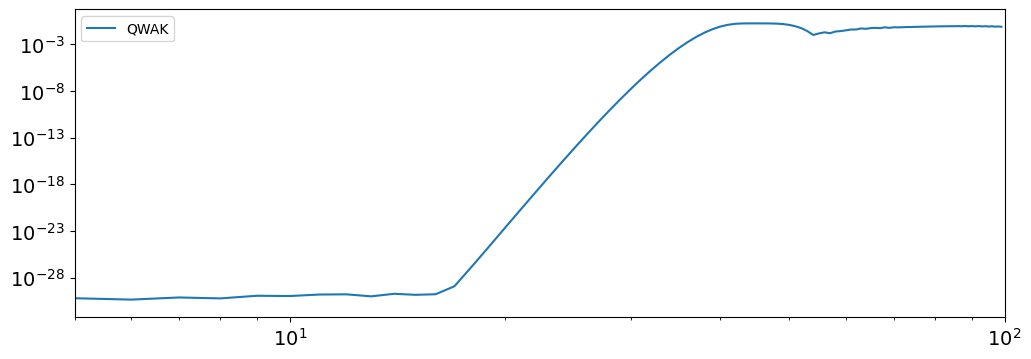

In [42]:
timeList = np.linspace(10,100,100)
qw.runMultipleWalks(timeList)

probDistList = qw.getProbDistList()
survProbList = qw.getSurvivalProbList(n//2-k-1,n//2+k+1)

# survProbList2 = getMultipleProbs(k,n,theta,l,gamma,[alpha],timeList)
# plt.plot(survProbList2[0],label="Bessel")

plt.loglog()
plt.plot(survProbList,label="QWAK")
plt.legend()
plt.xlim(5,100)